In [99]:
from z3 import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
set_param('parallel.enable', True)
z3.set_param('parallel.threads.max', 8)

Here we write the model at an RTT level. This method can only support calculating rates, and not calculating queuing delays. An alternate approach may allow us to calculate queuing delays (not not rates). Timesteps are in units of an RTT.

## Parameters
* $T$ - Number of RTTs to work for
* $B$ - BDP
* $K$ - Slack ($K = Ku - Kl, \forall t$)

**Note** This formulation only works if Only works if $K \ge C \cdot RTT = BDP$)

## Variables
If we wrote these variables in real time (instead of timesteps), think of them as right continuous
* $O_t$ - number of bytes output till timestep $t$ (not including wasted opportunities)
* $I_t$ - number of bytes input till timestep $t$
* $Ku_t, Kl_t$ - upper and lower slack. Can change if the server decides to waste transmission opportunities
* $w_t$ - cwnd at the beginning of timestep $t$
* $r_t$ - rate (in pkts / RTT) at during timestep $t$ (i.e. in $[t-1, t)$)

## Constraints
* $\min(I_{t-1}, B \cdot t - Kl_t) \le O_t \le B \cdot t + Ku_t$
* $I_t = I_{t-1} + \left[ O_{t-1} - O_{t-2} + w_t - w_{t-1} \right]^+$

In [115]:
s = Solver()

# Parameters of our system
T = 35
B = 10
K = B
# Otherwise our constraints are wrong
assert(K >= B)

# Create the variables
O = [Int("O_%d" % t) for t in range(T)]
I = [Int("I_%d" % t) for t in range(T)]
Ku = [Int("Ku_%d" % t) for t in range(T)]
Kl = [Int("Kl_%d" % t) for t in range(T)]
w = [Int("w_%d" % t) for t in range(T)]
r = [Int("r_%d" % t) for t in range(T)]

# The constraints
for t in range(1, T):
    # Constrain the output
    #lower_t = If(B * t - Kl[t] < I[t-1], B * t - Kl[t], I[t-1])
    s.add(B * t - Kl[t] <= O[t])
    s.add(O[t] <= B * t + Ku[t])
    s.add(O[t-1] <= O[t])
    
    # Outputs, windows and rates together decide how input changes
    if t > 1:
        # Change due to window
        I_w_c = O[t-1] + w[t]
        I_w = If(I_w_c > I[t-1], I_w_c, I[t-1])
        I_r = I[t - 1] + r[t - 1]
        s.add(I[t] == If(I_w < I_r, I_w, I_r))
    
    # Determine if we can waste transmissions
    waste_allowed = O[t] >= I[t-1]
    s.add(Implies(waste_allowed,
                  And(Ku[t] + B * t >= O[t],
                      Ku[t] <= Ku[t-1])))
    s.add(Implies(Not(waste_allowed),
                  And(Ku[t] == Ku[t-1],
                      Kl[t] == Kl[t-1])))
    s.add(Ku[t] + Kl[t] == K)
    s.add(I[t] >= O[t])
    
    # Implement BBR
    if t != 1:
        ## Find the maximum rate in the last 10 RTTs
        max_rate = O[t-1] - O[t-2]
        for delta_t in range(1,10):
            if t < delta_t - 1:
                break
            rate_t = O[t-delta_t] - O[t-delta_t-1]
            max_rate = If(max_rate < rate_t, rate_t, max_rate)

        ## Set the rate to max_rate * multiplier
        if t % 8 == 0:
            ### Probe
            s.add(r[t] == max_rate + max_rate / 4)
        elif t % 8 == 1:
            ### Drain probed packets
            s.add(r[t] == max_rate * 3 / 4)
        else:
            s.add(r[t] == max_rate)
        s.add(w[t] == 3 * max_rate + 1) 
    else:
        # Not enough info so far. Keep doing the same thing as before
        s.add(r[t] == r[t-1])
        s.add(w[t] == w[t-1])
    
# Our objective
#s.add(I[-1] < 150)
s.add(r[-1] < 6)

# Initial condition
s.add(O[0] == 0); s.add(O[1] == 0)
#s.add(I[0] == w[0]); s.add(I[1] == w[0])
s.add(I[0] == 0); s.add(I[1] == r[0])
s.add(Ku[0] == 0); s.add(Kl[0] == K)
s.add(r[0] == 10)
s.add(w[0] == 3 * r[0] + 1)

In [116]:
s.check()

unknown

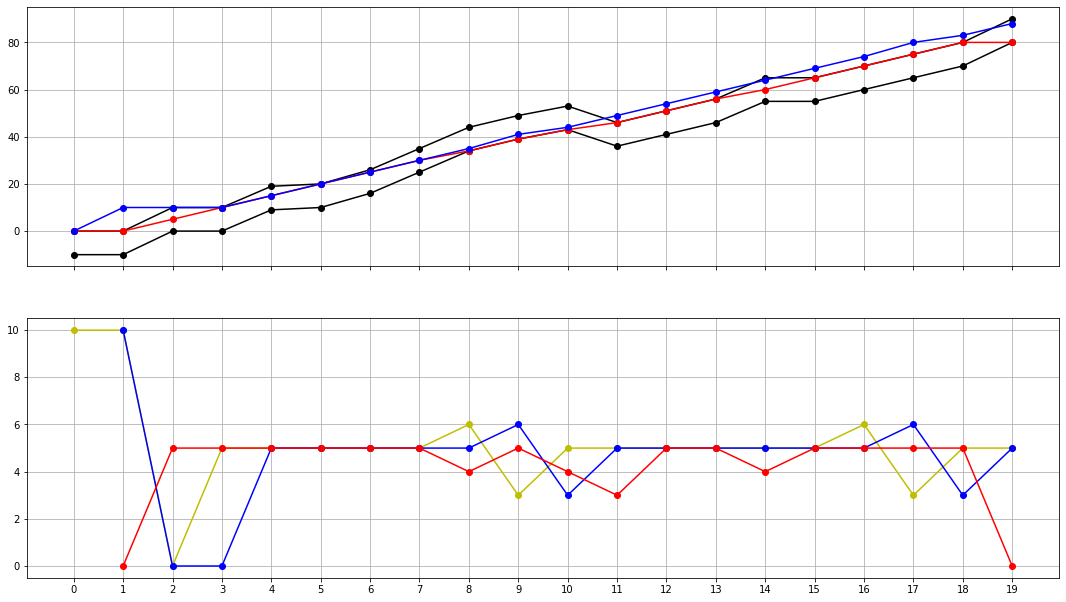

In [87]:
# Plot the model
m = s.model()
outputs = [m[o].as_long() for o in O]
inputs = [m[i].as_long() for i in I]
upper = [B * t + m[Ku[t]].as_long() for t in range(T)]
lower = [B * t - m[Kl[t]].as_long() for t in range(T)]
rates = [m[r[t]].as_long() for t in range(T)]
times = [t for t in range(T)]

outputs = np.asarray(outputs)
inputs = np.asarray(inputs)
upper = np.asarray(upper)
lower = np.asarray(lower)
rates = np.asarray(rates)
times = np.asarray(times)
adj = 0 #[B * t for t in range(T)]

# Configure the plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(18.5, 10.5)
ax1.grid(True)
ax2.grid(True)
ax2.set_xticks(range(0, T))
ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax1.plot(times, lower - adj, color='black', marker='o')
ax1.plot(times, upper - adj, color='black', marker='o')
ax1.plot(times, outputs - adj, color='red', marker='o')
ax1.plot(times, inputs - adj, color='blue', marker='o')

ax2.plot(times, rates, color='y', marker='o')
ax2.plot(times[1:], inputs[1:] - inputs[:-1], color='blue', marker='o')
ax2.plot(times[1:], outputs[1:] - outputs[:-1], color='red', marker='o')
#ax2.plot(times[1:], upper[1:] - upper[:-1], color='black', marker='o')
plt.show()


In [ ]:
upper = [m[Ku[t]].as_long() for t in range(T)]
lower = [- m[Kl[t]].as_long() for t in range(T)]
times = [t for t in range(T)]
plt.plot(times, upper)
plt.plot(times, lower)

In [26]:
print([x for x in zip(outputs, inputs, upper)])

[(0, 0, 0), (0, 1, 10), (15, 15, 20), (29, 34, 29), (33, 53, 39), (46, 71, 49), (58, 84, 59), (69, 96, 69), (79, 107, 79), (88, 109, 89), (96, 118, 99), (103, 126, 109), (109, 131, 119), (126, 135, 129), (138, 148, 138), (145, 165, 148), (150, 179, 158), (158, 184, 168), (169, 192, 178), (188, 203, 188)]


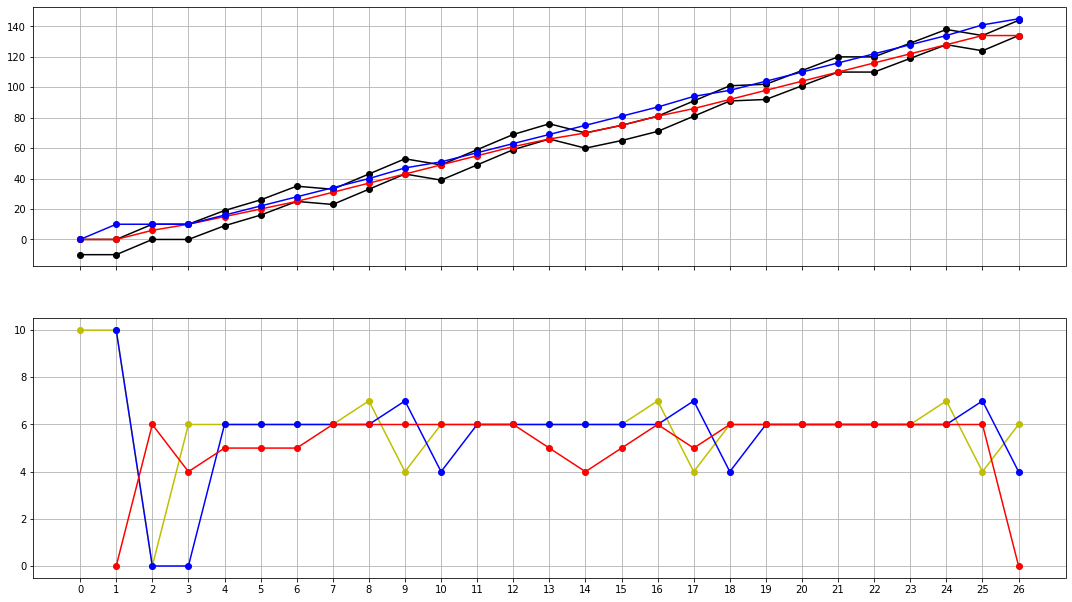

In [112]:
# Plot the model
m = s.model()
outputs = [m[o].as_long() for o in O]
inputs = [m[i].as_long() for i in I]
upper = [B * t + m[Ku[t]].as_long() for t in range(T)]
lower = [B * t - m[Kl[t]].as_long() for t in range(T)]
rates = [m[r[t]].as_long() for t in range(T)]
times = [t for t in range(T)]

outputs = np.asarray(outputs)
inputs = np.asarray(inputs)
upper = np.asarray(upper)
lower = np.asarray(lower)
rates = np.asarray(rates)
times = np.asarray(times)
adj = 0 #[B * t for t in range(T)]

# Configure the plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(18.5, 10.5)
ax1.grid(True)
ax2.grid(True)
ax2.set_xticks(range(0, T))
ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax1.plot(times, lower - adj, color='black', marker='o')
ax1.plot(times, upper - adj, color='black', marker='o')
ax1.plot(times, outputs - adj, color='red', marker='o')
ax1.plot(times, inputs - adj, color='blue', marker='o')

ax2.plot(times, rates, color='y', marker='o')
ax2.plot(times[1:], inputs[1:] - inputs[:-1], color='blue', marker='o')
ax2.plot(times[1:], outputs[1:] - outputs[:-1], color='red', marker='o')
#ax2.plot(times[1:], upper[1:] - upper[:-1], color='black', marker='o')
plt.show()